In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Implementation of constrained LMS algorithm
from Frost

We'll start by trying to replicate his results so we know that the algorithm is working correctly

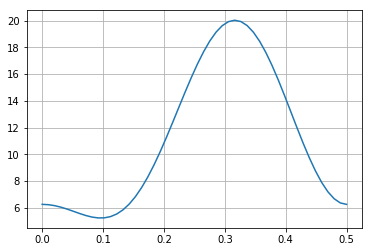

In [36]:
c = np.array([1, -2, 1.5, 2])

# Look at the frequency response of the filter up to the Nyquist frequency, and check it works properly
f = np.linspace(0, 0.5)
H = np.zeros(f.shape, dtype='complex128')
for k in range(4):
    H += c[k]*np.exp((k - 1.5)*1j*2*np.pi*f)

plt.plot(f, abs(H)**2)
plt.grid(True)
plt.xlabel('Frequency (Hz, normalised)')

Looks legit, c.f. Fig 9 of paper